In [1]:
import pandas as pd
from file_paths_and_consts import *
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
plt.style.use('classic')
import seaborn as sns
import geopandas as gpd
import random
sns.set()
import os
SEED_VALUE = 590
random.seed(SEED_VALUE)

OUTPUT_DIR

'/project/biocomplexity/UKR_forecast/migration_data/AAMAS_output_data/'

In [2]:
import multiprocessing as mp
import numpy as np
def calc_attitude_parallel(num):
    return num**2,num**3

def multiproc_attitude(all_nums):
    cpus = 4#mp.cpu_count()
    #st_time = time.time()
    hh_splits = np.array_split(all_nums, cpus) #--this a list with multiple dataframe.. each dataframe is used by one core
    #print(hh_splits)
    pool_args = [h_chunk for h_idx,h_chunk in enumerate(hh_splits)]
    #print('total time taken to split',time.time()-st_time)
    pool = mp.Pool(processes = cpus)
    results = pool.map(calc_attitude_parallel, pool_args)
    pool.close()
    pool.join()
    return results

ss = []

for i in range(0,100):
    ss.append(i)
    
results = multiproc_attitude(ss)
print(type(results[0][1]))

<class 'numpy.ndarray'>


In [3]:
pd.__version__

'1.1.0'

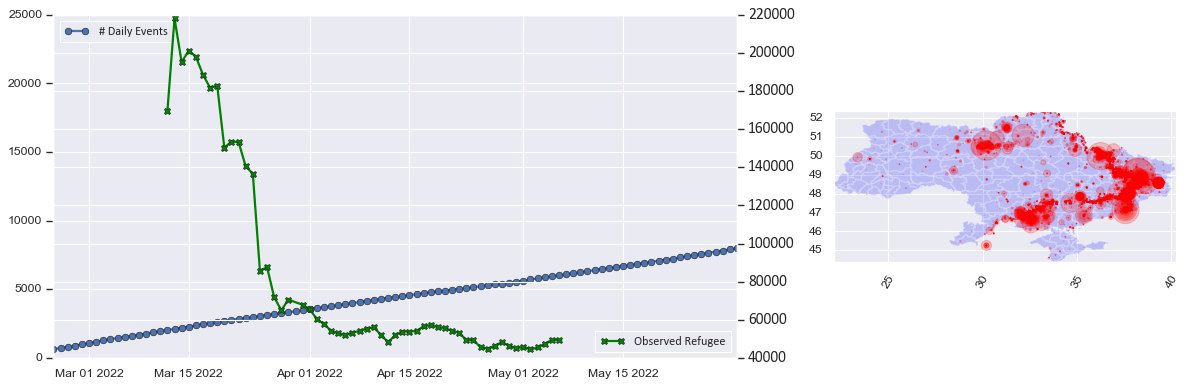

In [4]:
ROLLING = 12
conflict_data_file = UNCLEANED_DATA_DIR+'ukraine_conflict_data_feb_oct.csv'
refugee_data_file = GROUND_TRUTH_DIR+'ukraine_refugee_data_2.csv'
geo_shp_file = UNCLEANED_DATA_DIR+'UKR_shapefile_2/ukr_shp/ukr_admbnda_adm2_sspe_20230201.shp'

conflict_data = pd.read_csv(conflict_data_file)
conflict_data['time'] = pd.to_datetime(conflict_data['event_date'])
conflict_data = conflict_data.sort_values(by='time')
conflict_count = conflict_data[['time','fatalities']].groupby('time')['fatalities'].count().reset_index()
conflict_count['fatalities'] = conflict_count['fatalities'].cumsum()
conflict_count['fatalities'] = conflict_count['fatalities'].rolling(ROLLING).mean()
conflict_count = conflict_count.dropna(subset=['fatalities'])

refugee_data = pd.read_csv(refugee_data_file)
refugee_data['time'] = pd.to_datetime(refugee_data['time'])
refugee_data = refugee_data.sort_values(by='time')
refugee_data['refugee'] = refugee_data['refugee'].rolling(ROLLING).mean()
refugee_data = refugee_data.dropna(subset=['refugee'])
# refugee_data['refugee'] = refugee_data['refugee'].diff()
# refugee_data = refugee_data.dropna(subset=['refugee'])

burundi_gdf = gpd.read_file(geo_shp_file)

fig,ax = plt.subplots(1,2,figsize=(15,5),gridspec_kw={'width_ratios': [2, 1]})
plt.xticks(rotation=60)
rcParams["font.family"] = "calibri"
rcParams["font.size"] = 12
rcParams["axes.labelsize"] = 16
rcParams["axes.titlesize"] = 20
rcParams["xtick.labelsize"] = 14
rcParams["ytick.labelsize"] = 14

ax2 = ax[0].twinx()
ax2.plot(refugee_data['time'],refugee_data['refugee'],marker='X',linewidth=2,color='green',label='Observed Refugee')
ax[0].plot(conflict_count['time'],conflict_count['fatalities'],marker='o',linewidth=2,label='# Daily Events')
ax[0].set_xlim([datetime.date(2022, 2, 24), datetime.date(2022, 5, 31)])
#ax.set_ylim([conflict_count['fatalities'].min()-5,conflict_count['fatalities'].max()+5])
#ax2.set_ylim([refugee_data['refugee'].min()-500,refugee_data['refugee'].max()+500])
YLIM = [0,1000]
ax[0].legend(loc='upper left')
ax2.legend(loc='lower right')
#ax[0].set_ylim(YLIM)
fig.tight_layout()

burundi_gdf.plot(ax=ax[1],color='blue',alpha=0.2)
EPS = 0.1
SCALE = 2
conflict_data_gdf = gpd.GeoDataFrame(conflict_data,geometry=gpd.points_from_xy(conflict_data.longitude,conflict_data.latitude))
conflict_data_gdf.plot(ax=ax[1],color='red',alpha=0.2,markersize=(conflict_data['fatalities']+EPS)*SCALE)
ax[1].set_xlim(burundi_gdf.total_bounds[0], burundi_gdf.total_bounds[2])
ax[1].set_ylim(burundi_gdf.total_bounds[1], burundi_gdf.total_bounds[3])
fig.tight_layout()

In [5]:
all_ids = burundi_gdf['ADM2_EN'].tolist()

In [6]:
def get_results_for_2(hyper_comb, who='refugee',region_name=["all"],prefix='fresh_calib_batch_simulation',look_until=100,ROLL=7,partition = 40,scale_1 = 0.5,scale_2 = 2):
    search_in_ids = all_ids
    if region_name!=["all"]:
        search_in_ids = region_name
    
    all_dfs = []
    found = 0
    for cur_id in search_in_ids:
        #print(cur_id)
        f_name = prefix+'_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        f2_name = prefix+'_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        #print(f_name)
        if os.path.isfile(OUTPUT_DIR+f_name):
            true_f_name = f_name
        elif os.path.isfile(OUTPUT_DIR+f2_name):
            true_f_name = f2_name
        else:
            #print(cur_id,'not found')
            continue
            
        cur_df = pd.read_csv(OUTPUT_DIR+true_f_name)
        cur_df['time'] = pd.to_datetime(cur_df['time'])
        all_dfs.append(cur_df)
        found = found + 1
    
    ovr_df = pd.concat(all_dfs)
    ovr_df = ovr_df.groupby('time')[who].sum().reset_index()
    scale_list = [scale_1]*partition+[scale_2]*(ovr_df.shape[0]-partition)
    ovr_df['scale'] = scale_list
    ovr_df[who] = ovr_df[who]*ovr_df['scale']
    ovr_df[who] = ovr_df[who].rolling(ROLL).mean()
    #print(ovr_df.columns.tolist())
    ovr_df = ovr_df.dropna(subset=[who])
    print(found,'raions found')
    return ovr_df

def get_results_for_state(hyper_comb, who='refugee',region_name=["all"],prefix='fresh_calib_batch_simulation',look_until=100,ROLL=7,IDP_REFUGEE_PROB=0.1,partition = 40,scale_1 = 0.5,scale_2 = 2):
    OUTPUT_DIR_OLD = BASE_DIR+'output_data/' 
    search_in_ids = all_ids
    if region_name!=["all"]:
        search_in_ids = region_name
    
    all_dfs = []
    found = 0
    for cur_id in search_in_ids:
        #print(cur_id)
        f_name = prefix+'_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        f2_name = prefix+'_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        #print(f_name)
        if os.path.isfile(OUTPUT_DIR_OLD+f_name):
            true_f_name = f_name
        elif os.path.isfile(OUTPUT_DIR_OLD+f2_name):
            true_f_name = f2_name
        else:
            continue
            
        cur_df = pd.read_csv(OUTPUT_DIR_OLD+true_f_name)
        cur_df['time'] = pd.to_datetime(cur_df['time'])
        all_dfs.append(cur_df)
        found = found + 1
    
    ovr_df = pd.concat(all_dfs)
    ovr_df = ovr_df.groupby('time')['refugee'].sum().reset_index()
    
    #adjustment
    BORDER_CROSS_PROB = float(np.random.normal(0.32,0.02,1)[0])
    IDP_PROB = 1.0 - BORDER_CROSS_PROB
    #IDP_REFUGEE_PROB = 0.1
    ovr_df['FD'] = ovr_df['refugee']/BORDER_CROSS_PROB
    ovr_df['IDP'] = ovr_df['FD']*IDP_PROB
    
    f_list = ovr_df['FD'].tolist()
    r_list = ovr_df['refugee'].tolist()
    i_list = ovr_df['IDP'].tolist()
    
    for i in range(1,len(f_list)):
        i_list[i] = f_list[i]*IDP_PROB + i_list[i-1]*(1-IDP_REFUGEE_PROB)
    for i in range(1,len(f_list)):
        r_list[i] = f_list[i]*BORDER_CROSS_PROB + i_list[i-1]*(IDP_REFUGEE_PROB)
    
    ovr_df['refugee'] = r_list
    
    scale_list = [scale_1]*partition+[scale_2]*(ovr_df.shape[0]-partition)
    ovr_df['scale'] = scale_list
    ovr_df[who] = ovr_df[who]*ovr_df['scale']
    
    ovr_df[who] = ovr_df[who].rolling(ROLL).mean()
    #print(ovr_df.columns.tolist())
    ovr_df = ovr_df.dropna(subset=[who])
    print(found,'raions found')
    return ovr_df


def get_raion_list(hyper_comb, who='refugee',region_name=["all"],prefix='fresh_calib_batch_simulation',look_until=100,ROLL=7):
    
    search_in_ids = all_ids
    if region_name!=["all"]:
        search_in_ids = region_name
    
    all_dfs = []
    found = 0
    for cur_id in search_in_ids:
        #print(cur_id)
        f_name = prefix+'_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        #print(f_name)
        if os.path.isfile(OUTPUT_DIR+f_name):
            true_f_name = f_name
            all_dfs.append(cur_id)
        else:
            continue
            
    return set(all_dfs)

#get_results_for(777,prefix='mim')
def get_uncertainty_results(hyper_comb, region_name="all",prefix='fresh_calib_batch_simulation'):
    all_dfs = []
    if region_name=="all":
        col_to_sum = ['refugee','old_people','child','male','female']
        for cur_id in all_ids:
            f_name = prefix+'_result_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
            if os.path.isfile(OUTPUT_DIR+f_name):
                cur_df = pd.read_csv(OUTPUT_DIR+f_name)
                cur_df['time'] = pd.to_datetime(cur_df['time'])
                cur_df = cur_df.sort_values(by=['time','refugee'],ascending=[True,False])
                
                cur_df = cur_df.drop_duplicates(subset=['time'],keep='first')
                all_dfs.append(cur_df)
    return all_dfs

In [7]:
# ## compare if result looks same for a raion against two runs
# df1 = get_results_for_2(99950,region_name=['Kyiv'],prefix='mim_result')
# df2 = get_results_for_2(99969,region_name=['Kyiv'],prefix='mim_result')

# rcParams["font.family"] = "calibri"
# rcParams["font.size"] = 32
# rcParams["axes.labelsize"] = 28
# rcParams["axes.titlesize"] = 28
# rcParams["xtick.labelsize"] = 26
# rcParams["ytick.labelsize"] = 26

# fig,ax = plt.subplots(figsize=(14,5))
# plt.xticks(rotation=30)

# ax.plot(df1['time'],df1['refugee'],label='99950')
# ax.plot(df2['time'],df2['refugee'],label='99960')

# ax.set_xlim([datetime.date(2022, 3, 7), datetime.date(2022, 5, 6)])
# ax.legend(loc='best')
# df1['refugee'].corr(df2['refugee'])


In [8]:
macro_name = 'West'
#center - 2022-04-21
# south - 2022-03-22
# east - 2022-03-21
# north - 2022-03-15
# west = 2022-04-05

idp_df = pd.read_csv('ukr_idp_macro.csv')
particular_df = idp_df[idp_df.macro_region==macro_name]
particular_df['idp'] = particular_df['idp'].diff()
particular_df = particular_df.dropna(subset=['idp'])
particular_df['time'] = pd.to_datetime(particular_df['date'])
particular_df = particular_df.sort_values(by='time')
particular_df['idp'] = particular_df['idp'].rolling(ROLLING).mean()
particular_df = particular_df.dropna(subset=['idp'])
particular_df

/home/zm8bh/.conda/envs/biocomplexity/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,date,macro_region,idp,time
397,2022-03-20,West,99034.635520,2022-03-20
398,2022-03-21,West,82568.327184,2022-03-21
399,2022-03-22,West,68182.386609,2022-03-22
400,2022-03-23,West,55867.484531,2022-03-23
401,2022-03-24,West,45612.764676,2022-03-24
...,...,...,...,...
457,2022-05-19,West,-53100.000000,2022-05-19
458,2022-05-20,West,-58258.972437,2022-05-20
459,2022-05-21,West,-63417.944875,2022-05-21
460,2022-05-22,West,-68576.917312,2022-05-22


In [9]:
idp_macro_map = pd.read_csv('idp_macro.csv')
entire_gdf_ukr = burundi_gdf[['ADM2_EN','ADM1_EN','geometry']].merge(idp_macro_map,left_on='ADM1_EN',right_on='Oblast',how='inner')
raion_list = entire_gdf_ukr[entire_gdf_ukr['Macro-region']==macro_name]['ADM2_EN'].tolist()
raion_list

['Volodymyrskyi',
 'Kamin-Kashyrskyi',
 'Kovelskyi',
 'Lutskyi',
 'Berehivskyi',
 'Mukachivskyi',
 'Rakhivskyi',
 'Tiachivskyi',
 'Uzhhorodskyi',
 'Khustskyi',
 'Verkhovynskyi',
 'Ivano-Frankivskyi',
 'Kaluskyi',
 'Kolomyiskyi',
 'Kosivskyi',
 'Nadvirnianskyi',
 'Drohobytskyi',
 'Zolochivskyi',
 'Lvivskyi',
 'Sambirskyi',
 'Stryiskyi',
 'Chervonohradskyi',
 'Yavorivskyi',
 'Varaskyi',
 'Dubenskyi',
 'Rivnenskyi',
 'Sarnenskyi',
 'Kremenetskyi',
 'Ternopilskyi',
 'Chortkivskyi',
 'Kamianets-Podilskyi',
 'Khmelnytskyi',
 'Shepetivskyi',
 'Vyzhnytskyi',
 'Dnistrovskyi',
 'Chernivetskyi']

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

plt.style.use('classic')
import seaborn as sns
sns.set()

def get_uncertainty(sim_indices,first_df,q1=0.25,q3=0.75):
    #first_df = first_df[0:sz]
    run_cols = [str(i) for i in sim_indices if str(i) in first_df.columns.tolist()]
    medians = first_df[run_cols].median(axis=1)
    q1 = first_df[run_cols].quantile(q1, axis=1)
    q3 = first_df[run_cols].quantile(q3, axis=1)
    return medians,q1,q3


In [11]:


# #second_df = []

# for vv in simulation_indices_state:
#     print(vv,end=' ')
#     current_df = get_results_for_state(vv,prefix='mim_result',ROLL=7,IDP_REFUGEE_PROB=0.2,partition=40,scale_1=0.7,scale_2=0.5)
#     current_df['comb'] = str(vv)
#     #current_df_unsmoothed = get_results_for(vv,prefix='mim_result',ROLL=1)
#     #current_df_unsmoothed['comb'] = str(vv)

#     first_df_state.append(current_df)
#     #second_df.append(current_df_unsmoothed)
# first_df_state = pd.concat(first_df_state).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)
# #print(first_df.head())
# # mm = 1.5
# # ss = 38
# # for col in simulation_indices:
# #     first_df[str(col)][ss:] = first_df[str(col)][ss:]*mm
#     #print(first_df.head())
# #second_df = pd.concat(second_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)

In [12]:
%%time
import warnings
warnings.filterwarnings('ignore')

macro_regions = []
first_dfs = []
first_df_states = []

simulation_indices = [i for i in range(20000,20000+100)]
simulation_indices_state = [80000+i for i in range(9,18)]


for macro_name in ['Kyiv','Center','West','East','North','South']:
    
    print(macro_name)
    
    raion_list = entire_gdf_ukr[entire_gdf_ukr['Macro-region']==macro_name]['ADM2_EN'].tolist()
    
    first_df = []
    second_df = []

    for vv in simulation_indices:
        try:
            print(vv,end=' ')
            current_df = get_results_for_2(vv,region_name=raion_list,prefix='mim_result',ROLL=ROLLING,partition=42,scale_1=1.0*1.2*(0.68/0.32),scale_2=2.0*1.4*(0.68/0.32))
            current_df['comb'] = str(vv)
            first_df.append(current_df)
        except:
            continue

    first_df = pd.concat(first_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)
    macro_regions.append(macro_name)
    first_dfs.append(first_df)
    
    first_df_state = []
    
    for vv in simulation_indices_state:
        try:
            print(vv,end=' ')
            current_df = get_results_for_state(vv,region_name=raion_list,who='IDP',prefix='mim_result',ROLL=7,IDP_REFUGEE_PROB=0.2,partition=40,scale_1=0.7,scale_2=0.5)
            current_df['comb'] = str(vv)
            first_df_state.append(current_df)
        except:
            continue
    #second_df.append(current_df_unsmoothed)
    first_df_state = pd.concat(first_df_state).pivot(index='time',columns='comb',values='IDP').reset_index().fillna(0)
    first_df_states.append(first_df_state)

Kyiv
20000 1 raions found
20001 1 raions found
20002 1 raions found
20003 1 raions found
20004 1 raions found
20005 1 raions found
20006 1 raions found
20007 1 raions found
20008 1 raions found
20009 1 raions found
20010 1 raions found
20011 1 raions found
20012 1 raions found
20013 1 raions found
20014 1 raions found
20015 1 raions found
20016 1 raions found
20017 1 raions found
20018 1 raions found
20019 1 raions found
20020 1 raions found
20021 1 raions found
20022 1 raions found
20023 1 raions found
20024 1 raions found
20025 1 raions found
20026 1 raions found
20027 1 raions found
20028 1 raions found
20029 1 raions found
20030 1 raions found
20031 20032 1 raions found
20033 1 raions found
20034 1 raions found
20035 1 raions found
20036 1 raions found
20037 1 raions found
20038 1 raions found
20039 1 raions found
20040 1 raions found
20041 1 raions found
20042 1 raions found
20043 1 raions found
20044 1 raions found
20045 1 raions found
20046 1 raions found
20047 1 raions found
20

Kyiv
Center
West
East
North
South


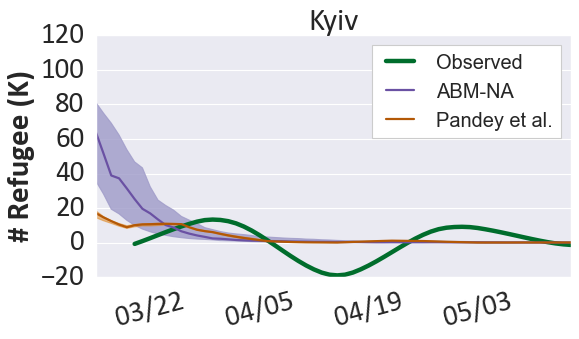

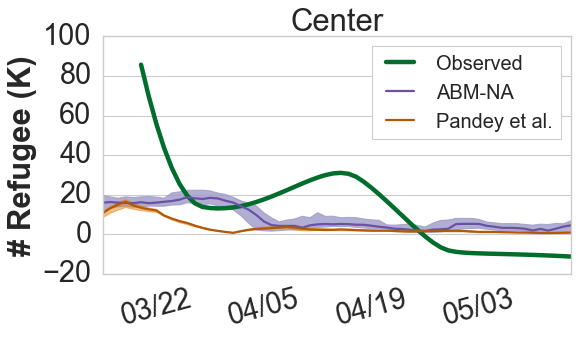

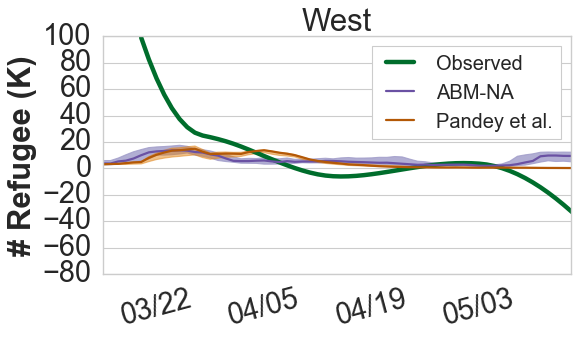

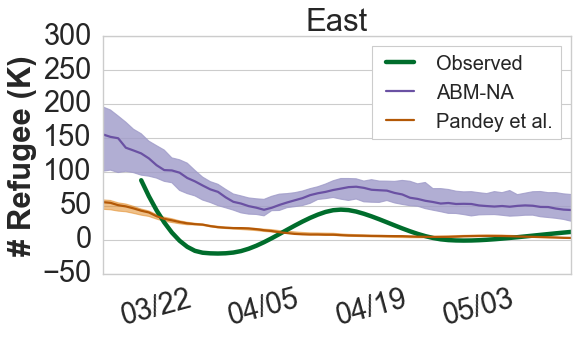

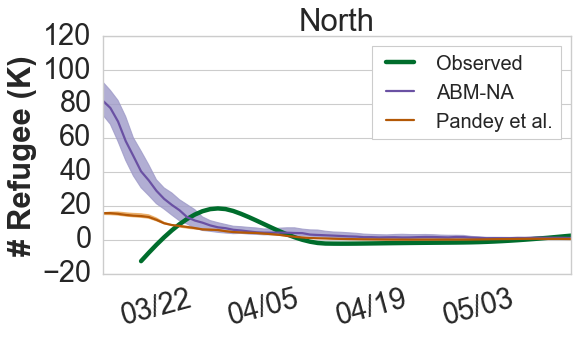

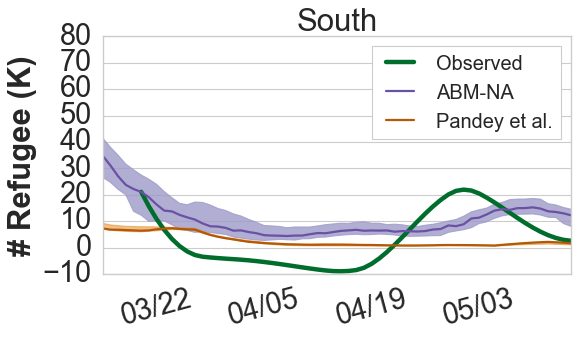

In [13]:
import datetime
import seaborn as sns
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates

# macro_regions = []
# first_dfs = []
# first_df_states = []

rcParams["font.family"] = "calibri"
rcParams["font.size"] = 32
rcParams["axes.labelsize"] = 28
rcParams["axes.titlesize"] = 28
rcParams["xtick.labelsize"] = 26
rcParams["ytick.labelsize"] = 26

trim = 7

for idx, macro_region in  enumerate(macro_regions):
    print(macro_region)
    #idp_df = pd.read_csv('ukr_idp_macro.csv')
    particular_df = idp_df[idp_df.macro_region==macro_region]
    particular_df['idp'] = particular_df['idp'].diff()
    particular_df = particular_df.dropna(subset=['idp'])
    particular_df['time'] = pd.to_datetime(particular_df['date'])
    particular_df = particular_df.sort_values(by='time')
    particular_df['idp'] = particular_df['idp'].rolling(ROLLING).mean()
    particular_df = particular_df.dropna(subset=['idp'])
    
    first_df = first_dfs[idx]
    first_df_state = first_df_states[idx]
    
    median_normal,q1_normal,q3_normal = get_uncertainty(simulation_indices,first_df,q1=0.35,q3=0.65)
    median_normal_state,q1_normal_state,q3_normal_state = get_uncertainty(simulation_indices_state,first_df_state,q1=0.35,q3=0.65)


    fig,ax = plt.subplots(figsize=(8,5))
    plt.xticks(rotation=15)

    ax.plot(particular_df['time'], particular_df['idp']/1000,label='Observed',linewidth=4,color='#006d2c')

    sns.set_style('white')
    SHIFT = -1
    ax.plot(first_df['time'][0:SHIFT],median_normal.shift(SHIFT)[0:SHIFT]/1000,linewidth=2,color='#6a51a3',alpha=1,label='ABM-NA')
    ax.fill_between(first_df["time"][0:SHIFT], q1_normal.shift(SHIFT)[0:SHIFT]/1000, q3_normal.shift(SHIFT)[0:SHIFT]/1000, color='#9e9ac8',alpha=0.8)
    ax.plot(first_df_state['time'],median_normal_state/1000,linewidth=2,color='#b35806',alpha=1,label='Pandey et al.')
    ax.fill_between(first_df_state['time'], q1_normal_state/1000, q3_normal_state/1000, color='#e08214',alpha=0.5)


    myFmt = mdates.DateFormatter('%m/%d')
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
    ax.xaxis.set_major_formatter(myFmt)


    sns.set_style('whitegrid')

    ax.legend(loc='best',ncol=1,fontsize=18)
    ax.set_ylabel("# Refugee (K)",fontweight='bold')
    ax.set_xlim([datetime.date(2022, 3, 15), datetime.date(2022, 5, 15)])
    ax.set_title(macro_region)
    ax.grid(axis='x')
    #print(ax.get_xticks())
    fig.tight_layout()
#fig.savefig('../Figures/aamas_abm_result.pdf',dpi=350,bbox_inches='tight')
#5110 porjonto bhalo